In [1]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 1.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

# Импорт

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn as nn
import pandas as pd
import zipfile
import os
import csv
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from pytorch_metric_learning import testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

# Загрузка аномального набора данных

In [3]:
zip_test = "Anom.zip"
imgzip = zipfile.ZipFile(zip_test, 'r')
imgzip.extractall()

iterator = 0
dataset_root = 'Anom'
csv_file_path = 'dataset.csv'
with open(csv_file_path, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['image', 'class'])
    for class_name in os.listdir(dataset_root):
        class_path = os.path.join(dataset_root, class_name)
        if os.path.isdir(class_path):
            iterator = iterator + 1
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                if os.path.isfile(image_path):
                    relative_image_path = os.path.relpath(image_path, dataset_root)
                    csv_writer.writerow([relative_image_path, iterator])

# Класс для создания кастомного набора данных для работы с pytorch

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, label_column='label'):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_column = label_column

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, self.img_labels.columns.get_loc(self.label_column)]
        if isinstance(label, str):
            try:
                label = int(label)
            except ValueError:
                print(f"Warning: Non-integer label encountered: {label}")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

# Определение модели

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 64)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]


# Загрузка модели

In [6]:
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()

Net(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

# Загрузка датасета

In [7]:
annotations_file = "dataset.csv"
img_dir = "Anom"
label_column = 'class'

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

anomalous_dataset = CustomImageDataset(annotations_file, img_dir, transform=test_transform, label_column=label_column)
anomalous_loader = DataLoader(anomalous_dataset, batch_size=16, shuffle=False)

# Функции для тестирования

In [23]:
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

def visualize_embeddings(embeddings, labels):
    embeddings = embeddings.cpu().numpy()
    labels = labels.cpu().numpy()
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.show()

# Визуализация векторов

100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


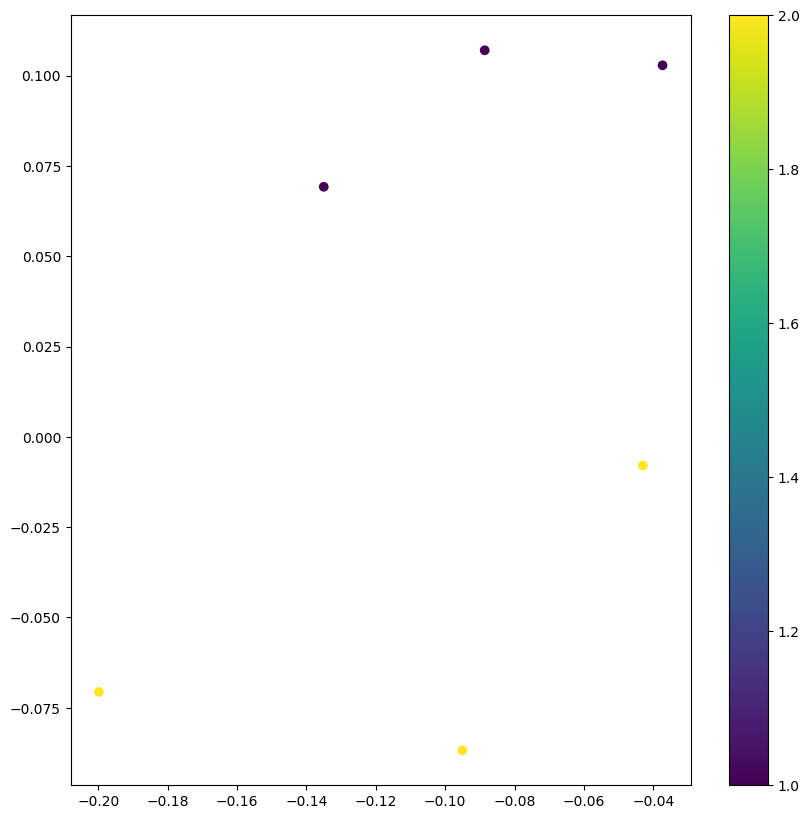

In [14]:
embeddings, labels = get_all_embeddings(anomalous_dataset, model)
visualize_embeddings(embeddings, labels)

## Вычисление процентного сходства для валидационного набора данных

In [37]:
import torch
import torch.nn.functional as F

def cosine_similarity(embedding1, embedding2):
    return F.cosine_similarity(embedding1, embedding2).item() * 100

def get_embedding(model, image, transform, device):
    model.eval()
    with torch.no_grad():
        image = transform(image).unsqueeze(0).to(device)
        embedding = model(image)
    return embedding

def calculate_average_similarity(model, train_loader, val_loader, device):
    model.eval()
    with torch.no_grad():
        train_embeddings = []
        train_labels = []
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            embeddings = model(data)
            train_embeddings.append(embeddings)
            train_labels.append(labels)
        train_embeddings = torch.cat(train_embeddings)
        train_labels = torch.cat(train_labels)
        class_1_indices = (train_labels == 2).nonzero(as_tuple=True)[0]
        class_1_embeddings = train_embeddings[class_1_indices]

        similarities = []
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            test_embeddings = model(data)
            for test_embedding, label in zip(test_embeddings, labels):
                cosine_similarities = F.cosine_similarity(test_embedding.unsqueeze(0), class_1_embeddings)
                avg_similarity = cosine_similarities.mean().item() * 100
                similarities.append(avg_similarity)
                print(f"Label: {label.item()}, Average Similarity: {avg_similarity:.2f}%")
    return similarities

average_similarities = calculate_average_similarity(model, anomalous_loader, anomalous_loader, device)

Label: 1, Average Similarity: 66.52%
Label: 1, Average Similarity: 68.80%
Label: 1, Average Similarity: 66.05%
Label: 2, Average Similarity: 92.98%
Label: 2, Average Similarity: 91.51%
Label: 2, Average Similarity: 90.66%


# Итоги

Так как данные являются аномальными для модели и такого класса, как "гречка с сосиской" не было в данных обученной модели, она выдала случайные классы на основе полученных векторов из новых изображений. Однако как можно увидет на графике векторного пространства, она объединяет подобные классы в группы и может отличить плохие и эталонные сервировки и выдать процент эталонности.